## Core of many industrial analytics solutions: Gaussian Processes regression

This notebook covers basic of Gaussian Process Regression:
* GPy library for GP modeling [SheffieldML github page](https://github.com/SheffieldML/GPy).
* Intro into Gaussian Process Regression
* Estimation of parameters of Gaussian Process Regression model
* Gaussian Process Classification
* Kernel selection for Gaussian process regression


Why **GPy**?

* Specialized library of GP models (regression, classification, GPLVM)
* Variety of covariance functions is implemented
* There are GP models for large-scale problems
* Easy to use

Current documentation of GPy library can be found [here](http://gpy.readthedocs.org/en/latest/).

Uncomment and run the following line to install GPy library

In [ ]:
!pip install GPy

In [64]:
%matplotlib notebook

from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import GPy

## Gaussian Process Regression

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

Assumption:
$$
y = f(x) + \varepsilon,
$$
where $f(x)$ is a Gaussian Process and $\varepsilon \sim \mathcal{N}(0, \sigma_0^2)$ is a Gaussian noise .

Posterior distribution
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^n \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
where
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_n) \right )^T,
$$
$$
\mathbf{K}_y = \{ k(x_i, x_j) \}_{i, j = 1}^n + \sigma_0^2 \mathbf{I}.
$$

## GP regression is a way to impose priors over wide range of functions

GP defines distribution over functions, which is defined by its *mean function* $m(x)$ and *covariance function* $k(x, x')$ for any set $\mathbf{x}_1, \ldots, \mathbf{x}_N \in \mathbb{R}^d \rightarrow$ $\left (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_n) \right ) \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$,
where $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_n))$, $\mathbf{K} = \{ k(\mathbf{x}_i, \mathbf{x}_j) \}_{i,j=1}^n$.

Sampling procedure:

1. Generate set of points $\mathbf{x}_1, \ldots, \mathbf{x}_n$.
2. Calculate mean and covariance matrix $\mathcal{m} = (m(\mathbf{x}_1, \ldots, \mathbf{x}_n)$, $\mathbf{K} = \{ k(\mathbf{x}_i, \mathbf{x}_j) \}_{i,j=1}^n$.
3. Generate vector from multivariate normal distribution $\mathcal{N}(\mathbf{m}, \mathbf{K})$.

<IPython.core.display.Javascript object>


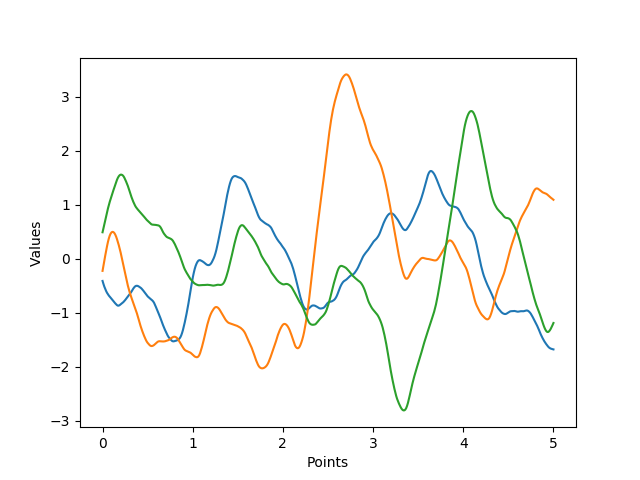

In [86]:
kernel = GPy.kern.Matern52(input_dim=1, lengthscale=0.3)

sample_size = 500
points = np.linspace(0, 5, sample_size).reshape(-1, 1)

mean_vector = np.zeros(sample_size)
covariance_matrix = kernel.K(points, points)

realizations = np.random.multivariate_normal(mean_vector, covariance_matrix, 3)

plt.figure()
for index in range(3):
    plt.plot(points, realizations[index, :])
plt.xlabel('Points')
plt.ylabel('Values')

## Building GPR model

Lets fit GPR model for function $f(x) = − \cos(\pi x) + \sin(4\pi x)$ in $[0, 1]$,
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

<IPython.core.display.Javascript object>


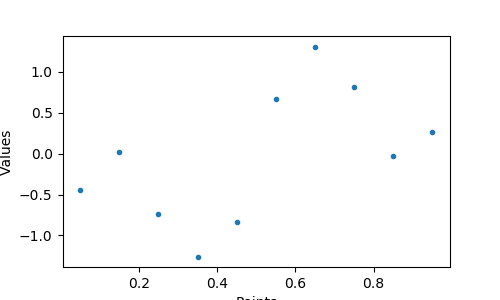

In [7]:
sample_size = 10
points = np.linspace(0.05, 0.95, sample_size).reshape(-1, 1)
values = (-np.cos(np.pi * points) + np.sin(4 * np.pi * points) +
     np.random.normal(loc=0.0, scale=0.1, size=(sample_size, 1)))

plt.figure(figsize=(5, 3))
plt.plot(points, values, '.')
plt.xlabel('Points')
plt.ylabel('Values')

#### 1. Define covariance function

The most popular kernel - RBF (or squared exponential) kernel - has 2 parameters: `variance` and `lengthscale`, $k(x, x') = \sigma^2 \exp\left ( -\dfrac{\|x - x'\|^2}{2l^2}\right )$,
where 
* `variance` is $\sigma^2$, 
* `lengthscale` is $l$.

In [8]:
input_dim = 1
variance = 1
lengthscale = 0.2
kernel = GPy.kern.RBF(input_dim, variance=variance,
                      lengthscale=lengthscale)

#### 2. Create GPR model


Name : GP regression
Objective : 13.116913613923007
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.2  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


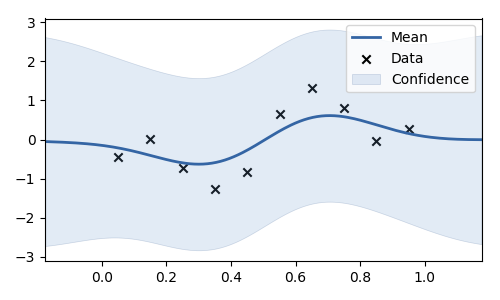

In [10]:
model = GPy.models.GPRegression(points, values, kernel)
print(model)
model.plot(figsize=(5, 3))

### Parameters of the covariance function

Values of parameters of covariance function can be set like:  `k.lengthscale = 0.1`.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

<IPython.core.display.Javascript object>


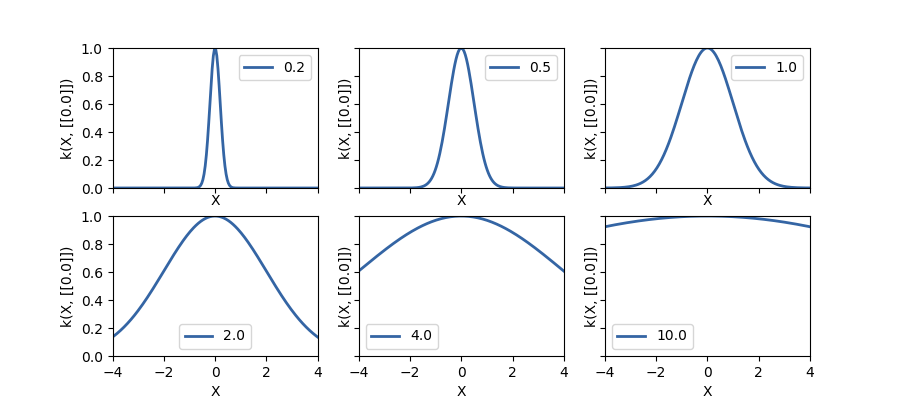

In [14]:
kernel = GPy.kern.RBF(1)
lengthscale_array = np.asarray([0.2, 0.5, 1, 2, 4, 10])
figure_handle, axes = plt.subplots(2, 3, figsize=(9, 4), sharex=True, sharey=True)
for lengthscale, selected_axes in zip(lengthscale_array, axes.ravel()):
    kernel.lengthscale = lengthscale
    kernel.plot(ax=selected_axes)
    ax.set_ylim([0, 1])
    ax.set_xlim([-4, 4])
    ax.legend([lengthscale])

<IPython.core.display.Javascript object>


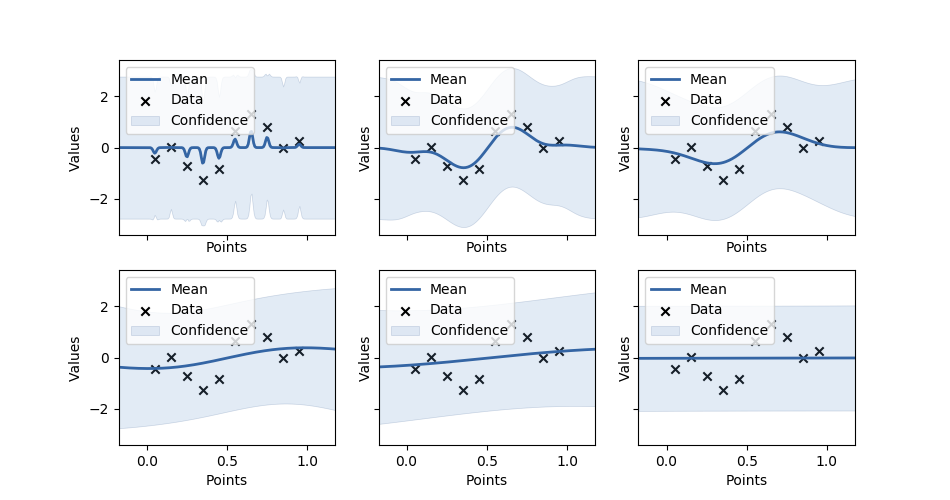

In [33]:
# Let us try to change parameters to obtain more accurate mdoel.
kernel = GPy.kern.RBF(1)
lengthscale_array = np.asarray([0.01, 0.1, 0.2, 0.5, 1, 10])
figure_handle, axes = plt.subplots(2, 3, figsize=(9.5, 5), sharex=True, sharey=True)

for lengthscale, selected_axes in zip(lengthscale_array, axes.ravel()):
  kernel.lengthscale = lengthscale
  model = GPy.models.GPRegression(points, values, kernel)
  # print(model)
  model.plot(ax=selected_axes)
  selected_axes.set_xlabel('Points')
  selected_axes.set_ylabel('Values')

## Tuning parameters of covariance function

The parameters are tuned by 
1. maximizing likelihood. To do it just use `optimize()` method of the model.
2. LOO CV score.

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.340534e+01   3.888071e+00 
    00s02  0006   9.017713e+00   4.375425e+00 
    00s05  0012   7.751161e+00   2.847127e-02 
    00s07  0016   7.746585e+00   3.405690e-09 
    00s07  0017   7.746585e+00   3.405690e-09 
Runtime:     00s07
Optimization status: Converged


Name : GP regression
Objective : 7.746584754926449
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |  0.791009200311  |      +ve      |        
  rbf.lengthscale          |  0.137741904875  |      +ve      |        
  Gaussian_noise.variance  |  0.016321050009  |      +ve      |        


<IPython.core.display.Javascript object>


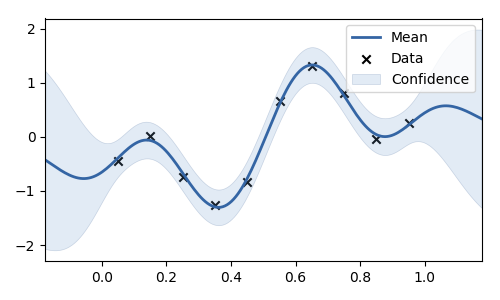

In [37]:
kernel = GPy.kern.RBF(1)
kernel.lengthscale = lengthscale = 0.1
model = GPy.models.GPRegression(points, values, kernel)

model.optimize(messages=True)
print(model)
model.plot(figsize=(5, 3))

### LOO CV score optimization 

`optimize()` maximizes likelihood.  However, for GP there is an expression for LOO predictive mean and variance
$$
\mu_i = y_i - \frac{ \left [ \mathbf{K}^{-1}\mathbf{y} \right ]_i }{\left [ \mathbf{K}^{-1} \right ]_{ii}},
$$
$$
\sigma_i = \frac{1}{\mathbf{K}^{-1}_{ii}}
$$
Then, e.g. MSE-LOO
$$
{\rm MSE-LOO} = \frac{1}{N}\sum_{i = 1}^N \left (\frac{\mathbf{K}^{-1}\mathbf{y}}{\mathbf{K}^{-1}_{ii}} \right )^2
$$

### Noise variance

Noise variance acts like a regularization in GP models. Larger values of noise variance lead to more smooth model.  
Let's check it: try to change noise variance to some large value, to some small value and see the results.

Noise variance accessed like this: `model.Gaussian_noise.variance = 1`

<IPython.core.display.Javascript object>


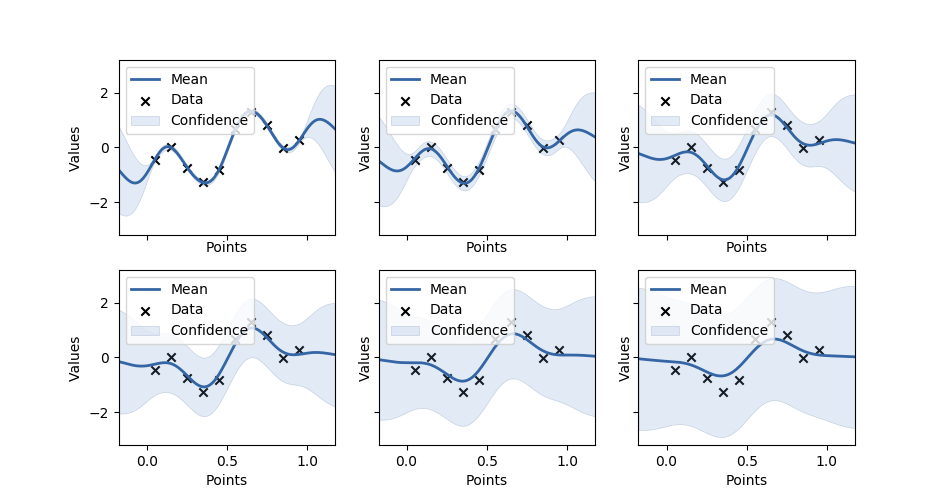

In [41]:
noise_variance_array = [1e-3, 1e-2, 0.1, 0.2, 0.5, 1]
figure_handle, axes = plt.subplots(2, 3, figsize=(9.5, 5), sharex=True, sharey=True)

for noise_variance, selected_axes in zip(noise_variance_array, axes.ravel()):
  model.Gaussian_noise.variance = noise_variance
  
  model.plot(ax=selected_axes)
  selected_axes.set_xlabel('Points')
  selected_axes.set_ylabel('Values')

# Gaussian Process Classification

### Classification

A data set $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \{+1, -1\} \right \}_{i = 1}^n$ is given.  

Assumption:
$$
p(y = +1 \; | \; x) = \sigma(f(x)) = \pi(x),
$$
where latent function $f(x)$ is a realization of Gaussian Process.

The probabilistic prediction has the form:
$$
\pi_* = p(y_* \; | \; X, \mathbf{y}, x_*) = \int \sigma(f_*) p(f_* \; | \; X, \mathbf{y}, x_*) df_*,
$$
$$
p(f_* \; | \; X, \mathbf{y}, x_*) = \int p(f_* \; | \; X, x_*, \mathbf{f}) p(\mathbf{f} \; | \; X, \mathbf{y}) d\mathbf{f},
$$
where $p(\mathbf{f} \; |\; X, \mathbf{y}) = \dfrac{p(\mathbf{y} | X, \mathbf{f}) p(\mathbf{f} | X)}{p(\mathbf{y} | X)}$ is the posterior over the latent variables.

*Both integrals are intractable.*

We need to use approximation technique like Laplace approximation or Expectation Propagation.

<IPython.core.display.Javascript object>


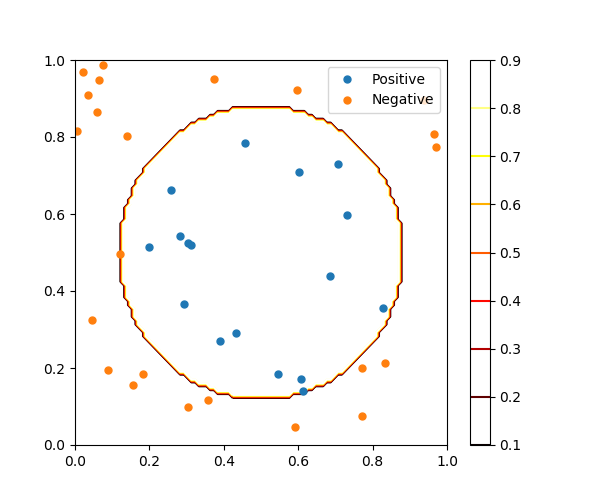

In [54]:
def cylinder(point):
  # toy function
  value = (1 / 7.0 - (point[:, 0] - 0.5)**2 - (point[:, 1] - 0.5)**2) > 0
  return value

np.random.seed(42)
points = np.random.rand(40, 2)
values = cylinder(points)

x_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
y_grid = cylinder(np.hstack((x_grid[0].reshape(-1, 1), x_grid[1].reshape(-1, 1)))).reshape(x_grid[0].shape)

positive_idx = values == 1
plt.figure(figsize=(6, 5))
plt.plot(points[positive_idx, 0], points[positive_idx, 1], '.', markersize=10, label='Positive')
plt.plot(points[~positive_idx, 0], points[~positive_idx, 1], '.', markersize=10, label='Negative')
im = plt.contour(x_grid[0], x_grid[1], y_grid, 10, cmap=cm.hot)

plt.colorbar(im)
plt.legend()
plt.show()


Name : gp_classification
Objective : 18.804442646769054
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp_classification.  |          value  |  constraints  |  priors
  rbf.variance        |  5.46917011561  |      +ve      |        
  rbf.lengthscale     |           (2,)  |      +ve      |        


<IPython.core.display.Javascript object>


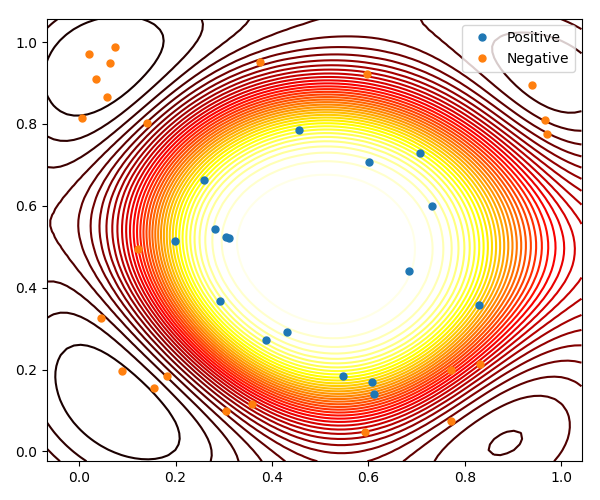

In [52]:
kernel = GPy.kern.RBF(2, variance=1., lengthscale=0.2, ARD=True)

model = GPy.models.GPClassification(points, values.reshape(-1, 1), kernel=kernel)
model.optimize()
print(model)


def plot_model_2d(model):
    model.plot(levels=40, resolution=80, plot_data=False, figsize=(6, 5))
    plt.plot(points[positive_idx, 0], points[positive_idx, 1], '.', markersize=10, label='Positive')
    plt.plot(points[~positive_idx, 0], points[~positive_idx, 1], '.', markersize=10, label='Negative')
    plt.legend()
    plt.show()
    
plot_model_2d(model)

Let's change lengthscale to some small value

<IPython.core.display.Javascript object>


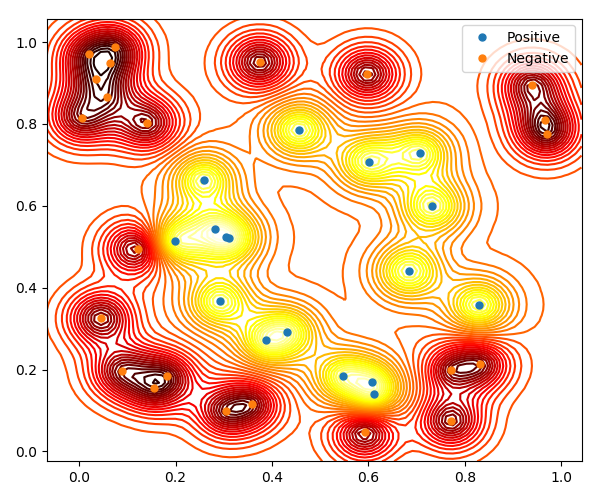

In [53]:
model.rbf.lengthscale = [0.05, 0.05]
plot_model_2d(model)

## More complex probabilistic models

We have to deal with even more complex models in Industrial engineering.

**Example:**
We need to deal with magnet that tries to catch as much particles as possible.
In this case 
$$
y \sim Pois(f(\mathbf{x})), 
$$
so $y$ is a Poisson random variable with parameter $f(\mathbf{x})$ that depends on configuration $\mathbf{x}$ of the magnet.

![magnet](magnet.png)



# Covariance functions

Short info about covariance function can be printed using `print(k)`. 

In [ ]:
kernel = GPy.kern.RBF(1)
print(kernel)

You can plot the covariance function using `plot()` method.

In [ ]:
k.plot(figsize=(5, 3))

### Heaviside function

The most popular covariance function is RBF. However, not all the functions can be modelled using RBF covariance function. For example, approximations of functions with large gradients or discontinuities will suffer from oscillations.

<IPython.core.display.Javascript object>


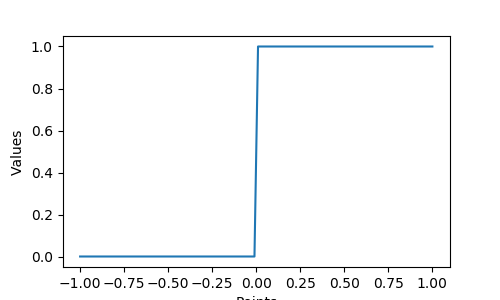

In [58]:
def heaviside(points):
    return np.asfarray(points > 0)

points = np.linspace(-1, 1, 100)
values = heaviside(points)
plt.figure(figsize=(5, 3))
plt.plot(points, values)
plt.xlabel('Points')
plt.ylabel('Values')


Name : GP regression
Objective : -16.673639020830592
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  rbf.variance             |    0.329609141254  |      +ve      |        
  rbf.lengthscale          |    0.158111386795  |      +ve      |        
  Gaussian_noise.variance  |  0.00177733412942  |      +ve      |        


<IPython.core.display.Javascript object>


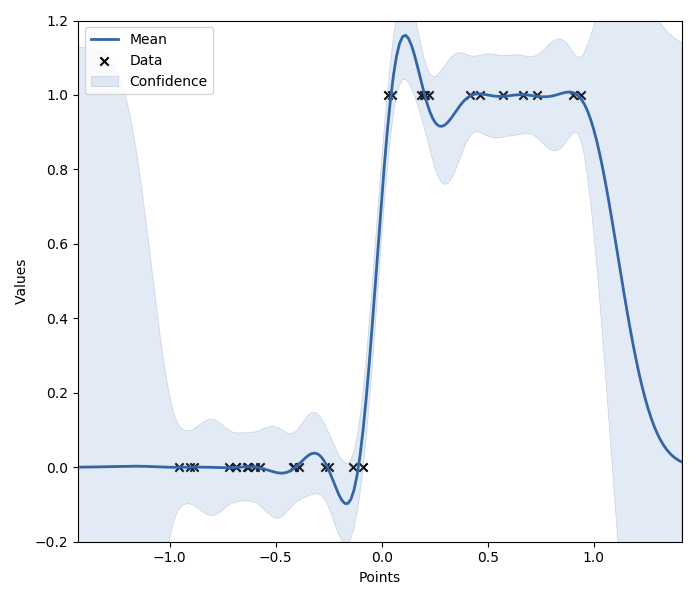

In [60]:
np.random.seed(42)
points = np.random.rand(30, 1) * 2 - 1
values = heaviside(points)

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

model = GPy.models.GPRegression(points, values, kernel)
model.optimize()
print(model)
model.plot(figsize=(7, 6))
plt.ylim([-0.2, 1.2])
plt.xlabel('Points')
plt.ylabel('Values')

### Covariance functions in GPy

Popular covariance functions: `Exponential`, `Matern32`, `Matern52`, `RatQuad`, `Linear`, `StdPeriodic`. 

* Exponential:
$$
k(x, x') = \sigma^2 \exp \left (-\frac{r}{l} \right), \quad r = \|x - x'\|
$$

* Matern32
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{3}\frac{r}{l} \right )\exp \left (-\sqrt{3}\frac{r}{l} \right )
$$

* Matern52
$$
k(x, x') = \sigma^2 \left (1 + \sqrt{5}\frac{r}{l} + \frac{5}{3}\frac{r^2}{l^2} \right ) \exp \left (-\sqrt{5}\frac{r}{l} \right )
$$

* RatQuad
$$
k(x, x') = \left ( 1 + \frac{r^2}{2\alpha l^2}\right )^{-\alpha}
$$

* Linear
$$
k(x, x') = \sum_i \sigma_i^2 x_i x_i'
$$

* Poly
$$
k(x, x') = \sigma^2 (x^T x' + c)^d
$$

* StdPeriodic
$$
k(x, x') = \sigma^2 \exp\left ( -2 \frac{\sin^2(\pi r)}{l^2}\right )
$$

<IPython.core.display.Javascript object>


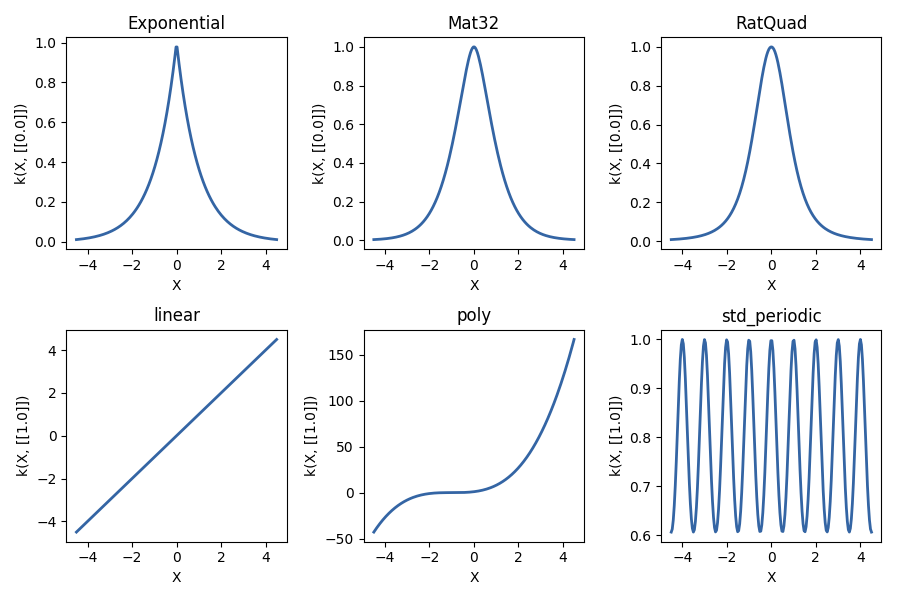

In [61]:
covariance_functions = [GPy.kern.Exponential(1), GPy.kern.Matern32(1),
                        GPy.kern.RatQuad(1), GPy.kern.Linear(1),
                        GPy.kern.Poly(1), GPy.kern.StdPeriodic(1)]
figure, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.ravel()
for index, kernel in enumerate(covariance_functions):
    kernel.plot(ax=axes[index])
    axes[index].set_title(kernel.name)
figure.tight_layout()

#### What covariance function we should use to obatin more accurate approximation of Heaviside function?

## Combinations of covariance functions

* Sum of covariance functions is a valid covariance function:

$$
k(x, x') = k_1(x, x') + k_2(x, x')
$$

* Product of covariance functions is a valid covariance funciton:
$$
k(x, x') = k_1(x, x') k_2(x, x')
$$

### Combinations of covariance functions in GPy

In GPy to combine covariance functions you can just use operators `+` and `*`.

For example, to define covariance function that is a sum of covariance functions we can do the following:

  sum.              |  value  |  constraints  |  priors
  linear.variances  |    1.0  |      +ve      |        
  rbf.variance      |    2.0  |      +ve      |        
  rbf.lengthscale   |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


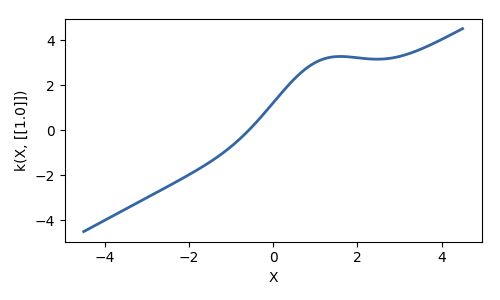

In [62]:
first_kernel = GPy.kern.Linear(1)
second_kernel = GPy.kern.RBF(1, variance=2., lengthscale=1)
kernel = first_kernel + second_kernel
print(kernel)
kernel.plot(figsize=(5, 3))

#### Linear times Periodic

  mul.                      |  value  |  constraints  |  priors
  linear.variances          |    1.0  |      +ve      |        
  std_periodic.variance     |    1.0  |      +ve      |        
  std_periodic.period       |    1.0  |      +ve      |        
  std_periodic.lengthscale  |    1.0  |      +ve      |        


<IPython.core.display.Javascript object>


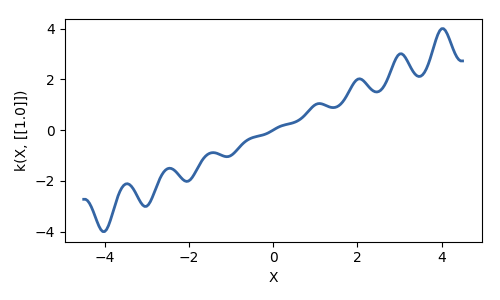

In [63]:
kernel = GPy.kern.Linear(1) * GPy.kern.StdPeriodic(1)
print(kernel)
kernel.plot(figsize=(5, 3))

## Additive kernels

One of the popular approach to model the function of interest is
$$
f(x) = \sum_{i=1}^d f_i(x_i) + \sum_{i < j} f_{ij}(x_i, x_j) + \ldots
$$

**Example**: $\quad f(x_1, x_2) = f_1(x_1) + f_2(x_2)$  
To model it using GP use additive kernel $\quad k(x, x') = k_1(x_1, x'_1) + k_2(x_2, x'_2)$.

More general - add kernels each depending on subset of inputs
$$
k(x, x') = k_1(x, x') + \ldots + k_D(x, x'),
$$
where, for example, $k_1(x, x') = k_1(x_1, x_1'), \; k_2(x, x') = k_2((x_1, x_3), (x_1', x_3'))$, etc.



In [ ]:
first_kernel = GPy.kern.RBF(1, active_dims=[0])
second_kernel = GPy.kern.RBF(1, active_dims=[1])

kernel = first_kernel + second_kernel

x = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
x = np.hstack((x[0].reshape(-1, 1), x[1].reshape(-1, 1)))
z = kernel.K(x, np.array([[0, 0]]))

figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')
ax.plot_surface(x[:, 0].reshape(50, 50), x[:, 1].reshape(50, 50), z.reshape(50, 50), cmap=cm.jet)
plt.show()

### Kernels on arbitrary types of objects

Kernels can be defined over all types of data structures: text, images, matrices, graphs, etc. You just need to define similarity between objects.

#### Kernels on categorical data

* Represent your categorical variable as a by a one-of-k encoding: $\quad x = (x_1, \ldots, x_k)$.
* Use RBF kernel with `ARD=True`: $\quad k(x , x') = \sigma^2 \prod_{i = 1}^k\exp{\left ( -\dfrac{(x_i - x_i')^2}{\sigma_i^2} \right )}$. The lengthscale will now encode whether the rest of the function changes.
* Short lengthscales for categorical variables means your model is not sharing any information between data of different categories. 

# Real data on international flights

Build a GP model that predicts airline passenger counts on international flights.

You need to obtain something like this
<img src="airline_result.png">

In [75]:
data = np.loadtxt('airline.csv', skiprows=1)
points = data[:, [0]]
values = data[:, [1]]

In [79]:
def plot_model(training_points, training_values, kernel):
    model = GPy.models.GPRegression(training_points, training_values, kernel)
    model.optimize()
    print(model)
    
    test_points = np.linspace(1948, 1964, 400).reshape(-1, 1)
    prediction_mean, prediction_var = model.predict(test_points)
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    
    plt.figure(figsize=(5, 3))
    plt.plot(points, values, '.', label='Training data')
    plt.plot(test_points, prediction_mean, label='Prediction')
    plt.fill_between(test_points.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, 
                     alpha=0.3, label='Confidence')
    plt.legend()

#### Let's try RBF kernel


Name : GP regression
Objective : 670.4420161378935
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  255653.899476  |      +ve      |        
  rbf.lengthscale          |  16.6224282552  |      +ve      |        
  Gaussian_noise.variance  |  1654.48105065  |      +ve      |        


<IPython.core.display.Javascript object>


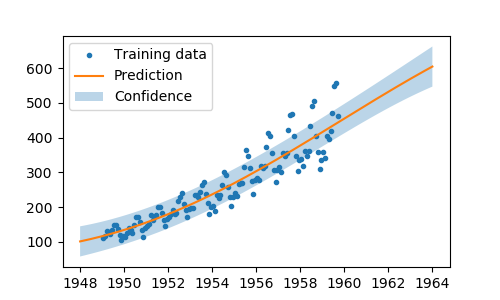

In [80]:
kernel_rbf = GPy.kern.RBF(1)
plot_model(points, values, kernel_rbf)

We will try to model this data set using 3 additive components: trend, seasonality and noise.  
So, the kernel should be a sum of 3 kernels:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`


Name : GP regression
Objective : 503.14032580389795
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                    |              value  |  constraints  |  priors
  sum.poly.variance                 |  1.66945653573e-06  |      +ve      |        
  sum.poly.scale                    |  1.66946477603e-06  |      +ve      |        
  sum.poly.bias                     |     0.999997389972  |      +ve      |        
  sum.rbf.variance                  |      100.133947788  |      +ve      |        
  sum.rbf.lengthscale               |     0.553610564476  |      +ve      |        
  sum.mul.std_periodic.variance     |     0.252682830011  |      +ve      |        
  sum.mul.std_periodic.period       |      1.00267495443  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |     0.532109561465  |      +ve      |        
  sum.mul.linear.variances          |     0.252682831015  |      +ve      |        
  sum.mul.rbf.v

<IPython.core.display.Javascript object>


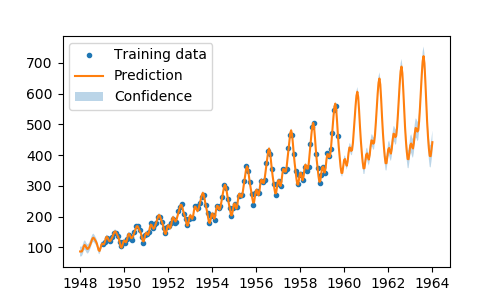

In [82]:
kernel_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1) # trend
kernel_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1) # periodicity
kernel_noise = GPy.kern.White(1) * GPy.kern.Linear(1) # noise

kernel = kernel_trend + kernel_periodicity + kernel_noise

plot_model(points, values, kernel)